# Assignment 2: Vision Transformers & Vision-Language Models

The first goal of this assignment is to understand how the transformer architecture introduced in the first assignment can be extended from text to images, resulting in a Vision Transformer (ViT). Then, you will learn more about joint modelling of text and image data, i.e. vision-language models (VLMs). Using Contrastive Language-Image Pretraining (CLIP) as a specific case study of VLMs, you will investigate how these models bridge modalities to enable tasks such as matching images to text 
prompts. 

Since VLMs are computationally very demanding to train (even for small datasets), you will work with already pretrained vision–language models based on the OpenCLIP architecture. You will evaluate their ability to associate histopathology images with textual concepts through the task of magnification prediction, which is defined as a binary classification distinguishing between low-power and high-power magnification in microscopy images (Figures 1 and 2). While this task holds limited clinical value (as pathologists do not need assistance identifying magnification), it is relatively simple and sufficient to demonstrate the ability of pre-trained models to encode and distinguish domain-specific visual features in their latent space. Although these categories are visually distinct, models pretrained on non-histopathology image-text pairs may not reliably associate these visual patterns with such domain-specific textual labels.

To address cases when the ViT encodes meaningful features of domain-specific images but does not have the concepts explicitly labeled, we will first introduce a linear probing technique. Linear probing involves training a lightweight classifier on top of **frozen** image embeddings to test whether the relevant information is already present in the representation (latent) space of the vision encoder. This technique allows us to use the learned image representation for classification tasks without retraining the vision transformer (which would be computationally expensive).

Finally, we will compare the linear probing results with the zero-shot classification performance of two vision transformers with the same architecture but pretrained on different datasets: one on general natural images and one on medical images. Zero-shot classification involves using the pretrained alignment between text and images to classify data into categories that were not explicitly seen during the model's training. 

As in the previous assignment, we will use the [Open-MELON dataset](https://huggingface.co/datasets/MartiHan/Open-MELON-VL-2.5K) for both of these tasks. 

![Low-power view example](assets/low_power_example.png)

*Figure 1: Example of low-power (low-magnification) view from Open-MELON dataset*

![High-power view example](assets/high_power_example.png)

*Figure 2: Example of high-power (high-magnification) view from Open-MELON dataset*

## Preparation

This is a list of materials that you can use to learn the topic of Transformers and prepare for the flipped classrooms:

| Type | Length | Link | Why is it relevant? |
| :--- | :--- | :--- | :--- |
| Paper | 9 pg. (w/o supplementary material)| [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al.)](https://arxiv.org/abs/2010.11929) | This is the paper that introduced the Vision Transformer (ViT) model. ViT uses the encoder part of the original Transformer architecture to process images as sequences of patches. There is no causal masking, meaning that each image patch (i.e. image "word") can "see"/attend to all other patches in the image. This enables the model to build a global understanding of the complete image. As with the Transformers models for text, positional embedding of the patches is used. Its primary goal is to map the input image into a fixed vector representation (using a special `[CLS]` token) for classification tasks, rather than generating a new sequence of data autoregressively.|
| Video | 30 min. | [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Paper Explained)(Yannic Kilcher)](https://www.youtube.com/watch?v=TrdevFK_am4) | This is a very good explanation of the ViT paper. It goes through the key concepts and explains them in a clear and concise manner. You can iterate between reading (parts of) the paper and watching the video to deepen your understanding.|
| Paper | 27 pg. (w/o supplementary material) | [Learning Transferable Visual Models From Natural Language Supervision (Radford et al.)](https://arxiv.org/abs/2103.00020) | This paper introduces CLIP (Contrastive Language-Image Pre-training). It uses a Vision Transformer (ViT) as the image encoder and trains it jointly with a text encoder to predict correct image-text pairs. This demonstrates how the fixed vector representation (e.g., from the `[CLS]` token) of a ViT can be aligned with natural language, enabling the model to perform zero-shot classification on entirely new tasks without specific training labels. |
| Video | 48 min. | [OpenAI CLIP: Connecting Text and Images (Paper Explained) (Yannic Kilcher)](https://www.youtube.com/watch?v=T9XSU0pKX2E) | This video breaks down the CLIP paper, explaining exactly how the ViT image encoder and text encoder are trained together using contrastive loss. It visually walks through the architecture and the results, making the concept of "zero-shot transfer" (using the model on new tasks without fine-tuning) much easier to understand. |





## Exercises: Theory 

⚠️ *The answers to the theory exercises are NOT to be submitted as part of the assignment deliverables. They can, however, be used to check your understanding of the materials and to prepare for the flipped classroom. You CAN include your discussion about the exercises in the flipped classroom log.*


#### Exercise T.1

In the standard ViT architecture, a special learnable vector called the `[CLS]` (classification) token is prepended to the sequence of patch embeddings. The final state of this specific token acts as the aggregate representation of the entire image and is fed to the classifier.

Assume that you modify the architecture to discard the `[CLS]` token. Instead, you use the final output state corresponding to the top-left patch of the image to drive the classification. Will this "still work"? Are there any up- or down-sides to taking this approach?

Can you think of or have you encountered any other approaches to aggregate the patch representations into a global image embedding?

#### Exercise T.2

The input of a ViT is a sequence of vectors, created by flattening patches and multiplying them by a learnable weight matrix $\textbf{E}$. If a model is pre-trained on ImageNet (standard photographs), the weight matrix $\textbf{E}$ is shaped to accept patches with 3 color channels (Red, Green, Blue).

You want to fine-tune this pre-trained ViT on Multiparametric MRI data of the prostate. To capture the full clinical context, you stack four specific sequences into the channel dimension: T2-weighted, Diffusion-weighted (DWI), Apparent Diffusion Coefficient (ADC), and Dynamic Contrast Enhanced (DCE). Your input images now have 4 channels. Propose some solutions to the dimensionality mismatch between the pre-trained model and your data.

#### Exercise T.3

In a CNN, the "receptive field" of a neuron in the first layer is strictly limited to a small kernel (e.g., 3×3 pixels). It cannot process or relate information outside this region. Is the same limitation present in ViTs? 


#### Exercise T.4

CLIP is trained using a Contrastive Loss function (specifically InfoNCE). For a batch of $N$ image-text pairs, the model maximizes the cosine similarity of the N correct pairings on the diagonal while minimizing the similarity of the $N^2−N$ incorrect pairings.

You attempt to train a CLIP model from scratch on a massive dataset, but due to GPU memory constraints, you set the batch size to a very small number (e.g., $N$=8).

Why does the model fail to learn meaningful representations, even if you train it for a very long time?

## Applying a Vision-Language Model

### Install Required Packages

This notebook uses:
- `datasets` (Hugging Face) for dataset loading
- `transformers` for pre-trained models
- `open_clip_torch` for the OpenCLIP model
- `scikit-learn` for metrics and PCA
- `pillow` for image manipulation
- `matplotlib` for result visualization
- `tqdm` for displaying progress bars

Let's install the required packages:

In [11]:
!pip install datasets transformers open_clip_torch scikit-learn pillow matplotlib tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Import the Libraries

The following Python modules will be used for ViT models evaluation and visualization of the results.

In [13]:
import os
import random
import numpy as np
import torch
import open_clip
from PIL import Image
from typing import List, Dict, Any, Tuple
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from datasets import concatenate_datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report


### Environment Configuration
Evaluation of the ViTs may be very slow on CPU-only laptops when applying to a full dataset. Code block below automatically detects whether a GPU is present and applies configuration accordingly.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

BATCH_SIZE = 32

### Load the Dataset


In [15]:
ds_train, ds_test = load_dataset("MartiHan/Open-MELON-VL-2.5K", split=["train", "test"])
print(ds_train, ds_test)

Dataset({
    features: ['pmc_id', 'figure_id', 'panel_id', 'caption', 'image', 'magnification'],
    num_rows: 1726
}) Dataset({
    features: ['pmc_id', 'figure_id', 'panel_id', 'caption', 'image', 'magnification'],
    num_rows: 398
})


### Load the OpenCLIP Models

We now download two pretrained OpenCLIP models from HuggingFace Hub, both based on [ViT-B-16](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html) architecture.

For a general model, a standard checkpoint `laion2b_s34b_b88k` is selected with deafult tokenizer. For a model trained on medical image-text pairs we will use [OpenCLIP-BiomedCLIP-Finetuned](https://huggingface.co/mgbam/OpenCLIP-BiomedCLIP-Finetuned).

In [17]:

# ViT pretrained on general dataset
model_general, preprocess_train, preprocess_val = open_clip.create_model_and_transforms("ViT-B-16", pretrained="laion2b_s34b_b88k", device=device)
tokenizer_general = open_clip.get_tokenizer("ViT-B-16")

# ViT pretrained on medical dataset
model_medical, preprocess_train, preprocess_val = open_clip.create_model_and_transforms("hf-hub:mgbam/OpenCLIP-BiomedCLIP-Finetuned", pretrained=None, device=device)
tokenizer_medical = open_clip.get_tokenizer("hf-hub:mgbam/OpenCLIP-BiomedCLIP-Finetuned")


### Dataset Wrapper

As mentioned, we will utilize the Open-MELON dataset to perform an illustrative classification task predicting image magnification (low vs. high power). The code below is a PyTorch data pipeline that filters the Open-MELON dataset to keep only images with valid magnification metadata and categorizes them into "low-power" or "high-power". This established the ground truth for our task. It also applies necessary image preprocessing transformations and initializes DataLoader instances to efficiently batch and stack these tensors alongside their text labels for use in models.

In [21]:
class HFDatasetImages(Dataset):
    def __init__(self, hf_ds, preprocess):
        self.ds = hf_ds
        self.preprocess = preprocess

        # keep only samples with known magnification
        self.valid_indices = []
        for i in range(len(self.ds)):
            if self.ds[i].get("magnification", None) is not None:
                self.valid_indices.append(i)

        print(f"Kept {len(self.valid_indices)} / {len(self.ds)} samples")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        ex = self.ds[self.valid_indices[idx]]

        img = ex["image"].convert("RGB")
        try:
            mag_num = int(ex["magnification"])
            if mag_num <= 80:
                mag_label = "low-power"
            else:
                mag_label = "high-power"
        except:
            mag_label = ex["magnification"]

        x_img = self.preprocess(img)
        return x_img, mag_label

def collate_fn(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return imgs, list(labels)

loader_train = DataLoader(
    HFDatasetImages(ds_train, preprocess_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)

loader_test = DataLoader(
    HFDatasetImages(ds_test, preprocess_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)


Kept 1541 / 1726 samples
Kept 344 / 398 samples


### Generate Image Embeddings


The two loaded OpenCLIP models will be used to generate embeddings for both training and testing set. In Colab, the evaluation might take up to 30 minutes on the CPU-only session, and approximatelly 1 minute on GPU.

In [ ]:
@torch.no_grad()
def compute_image_embeddings(dataloader, model, device):
    img_embs = []
    labels = []

    model.eval()

    for imgs, labs in dataloader:
        imgs = imgs.to(device, non_blocking=True)

        feats = model.encode_image(imgs)
        feats = feats / feats.norm(dim=-1, keepdim=True)

        img_embs.append(feats.cpu().numpy())
        labels.extend(labs)

    return np.vstack(img_embs), labels

#### Medical OpenCLIP model ####
img_emb_med_train, labels_train = compute_image_embeddings(loader_train, model_medical, device)
print("Train embeddings:", img_emb_med_train.shape)

img_emb_med_test, labels_test = compute_image_embeddings(loader_test, model_medical, device)
print("Test embeddings:", img_emb_med_test.shape)

#### General OpenCLIP model ####
img_emb_gen_train, labels_train = compute_image_embeddings(loader_train, model_general, device)
print("Train embeddings:", img_emb_gen_train.shape)

img_emb_gen_test, labels_test = compute_image_embeddings(loader_test, model_general, device)
print("Test embeddings:", img_emb_gen_test.shape)


Train embeddings: (1541, 512)
Test embeddings: (344, 512)
Train embeddings: (1541, 512)
Test embeddings: (344, 512)


### Visualizing the Embeddings

The produced image embeddings are high-dimensional vectors (512 dimensions) that capture visual information learned by the vision transformer. To better understand how these embeddings are organized, we use Principal Component Analysis (PCA) to project them into a two-dimensional space that can be visualized.

PCA is a linear dimensionality reduction technique that finds directions (principal components) along which the data varies the most. When we project the embeddings onto the first two principal components, we preserve as much of the original variance as possible while reducing the dimensionality. Importantly, PCA does not use class labels; it reflects only the structure present in the embeddings themselves.

For visualization purposes, we concatenate the training and testing sets and apply PCA to the combined embeddings. Each point in the resulting plot represents one image, positioned according to its embedding in the reduced space. Points that are close together correspond to images with similar embeddings, while points that are far apart indicate greater dissimilarity as perceived by the model.

It is important to note that PCA is only a visualization tool: separation in the plot does not directly imply classification performance. However, such plots are valuable for building intuition about what information the model has learned and how are different visual factors reflected in the embedding space.

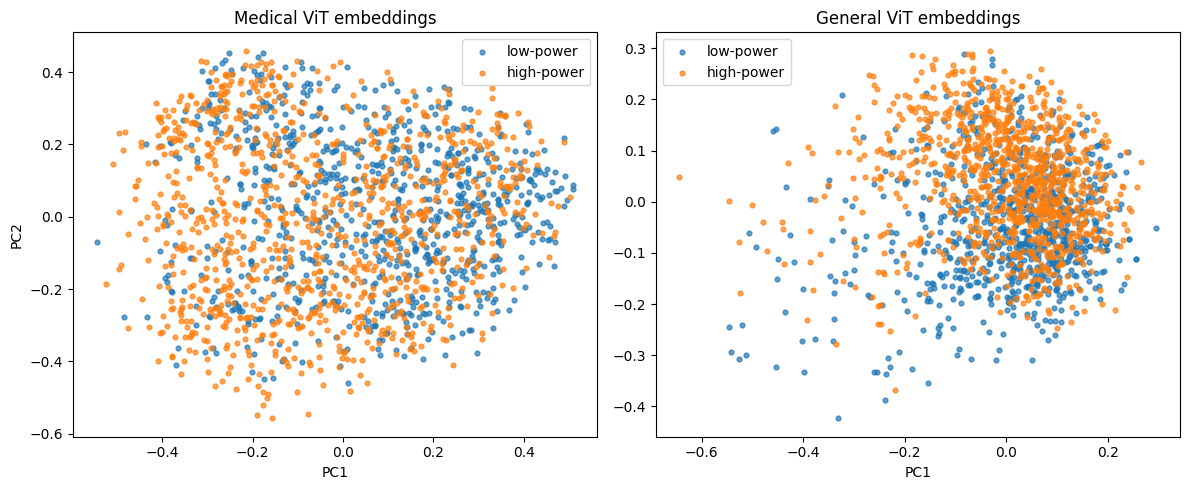

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- concatenate train + test ---
img_emb_med = np.concatenate([img_emb_med_train, img_emb_med_test], axis=0)
labels  = np.concatenate([labels_train, labels_test], axis=0)

img_emb_gen = np.concatenate([img_emb_gen_train, img_emb_gen_test], axis=0)

y_labels = np.array([1 if c == "high-power" else 0 for c in labels])

# --- PCA projections ---
pca = PCA(n_components=2, random_state=42)

X_med = pca.fit_transform(img_emb_med)
X_gen = pca.fit_transform(img_emb_gen)

# --- plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Medical ViT
axes[0].scatter(X_med[y_labels == 0, 0], X_med[y_labels == 0, 1],
                s=12, alpha=0.7, label="low-power")
axes[0].scatter(X_med[y_labels == 1, 0], X_med[y_labels == 1, 1],
                s=12, alpha=0.7, label="high-power")
axes[0].set_title("Medical ViT embeddings")
axes[0].legend()
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# General ViT
axes[1].scatter(X_gen[y_labels == 0, 0], X_gen[y_labels == 0, 1],
                s=12, alpha=0.7, label="low-power")
axes[1].scatter(X_gen[y_labels == 1, 0], X_gen[y_labels == 1, 1],
                s=12, alpha=0.7, label="high-power")
axes[1].set_title("General ViT embeddings")
axes[1].legend()
axes[1].set_xlabel("PC1")

plt.tight_layout()
plt.show()


When examining the results, you may observe that embeddings from the medical vision transformer show somewhat clearer separation between low-power and high-power images compared to the general vision transformer. This suggests that magnification-related information is more explicitly encoded in the representations of the medical model.

### Linear Probing
To better understand whether magnification information is present in the image embeddings themselves (independently of language alignment) we now apply linear probing. In linear probing, we freeze the image embeddings and train a logistic regression classifier on top of them using labeled data. This classifier learns the optimal linear weights directly from the data, rather than relying on fixed weights derived from text prompts.

In [28]:
def make_binary_labels(labels):
    """
    Convert string labels to binary:
    low-power -> 0
    high-power -> 1
    """
    return np.array(
        [1 if c == "high-power" else 0 for c in labels],
        dtype=np.int32
    )

def linear_probe(
    X_train, y_train,
    X_test,  y_test,
    max_iter=2000,
    class_weight="balanced"
):
    # Standardize features
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std  = scaler.transform(X_test)

    # Train logistic regression
    clf = LogisticRegression(
        max_iter=max_iter,
        class_weight=class_weight
    )
    clf.fit(X_train_std, y_train)

    # Probabilities for positive class
    y_prob = clf.predict_proba(X_test_std)[:, 1]

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    return {
        "model": clf,
        "scaler": scaler,
        "y_prob": y_prob,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc,
    }


y_train = make_binary_labels(labels_train)
y_test  = make_binary_labels(labels_test)


print("Class balance:", np.bincount(y_train))

print("#### Logistic Regression on Medical ViT ###")

lr_med = linear_probe(
    X_train=img_emb_med_train,
    y_train=y_train,
    X_test=img_emb_med_test,
    y_test=y_test
)

print(f"-AUC score: {lr_med["auc"]:.2f}/1.00")

print("#### Logistic Regression on General ViT ###")

lr_gen = linear_probe(
    X_train=img_emb_gen_train,
    y_train=y_train,
    X_test=img_emb_gen_test,
    y_test=y_test
)

print(f"-AUC score: {lr_gen["auc"]:.2f}/1.00")


Class balance: [710 831]
#### Logistic Regression on Medical ViT ###
-AUC score: 0.74/1.00
#### Logistic Regression on General ViT ###
-AUC score: 0.68/1.00


### Zero-shot Model Evaluation
So far, we have only used the image encoder, effectively treating OpenCLIP as a standard vision backbone model. We have not yet made use of the text encoder or the aligned latent space that characterizes Vision-Language Models.

One way we can do that is by exploiting the contrastive nature of the pretraining. Because the model was optimized to maximize the similarity between matching image-text pairs, we can classify images by directly comparing their embeddings to the embeddings of potential text labels.

In the following code, we define two simple text prompts—"low-power" and "high-power"—encode them using the text encoder, and compute cosine similarities between the image and text embeddings. The resulting similarity scores are converted into class probabilities using a softmax function, allowing us to evaluate the so called "zero-shot" classification performance without training a specific classifier.

Unlike linear probing, zero-shot evaluation does not learn any task-specific classifier from labeled data. Instead, it relies entirely on the alignment between image and text embeddings learned during contrastive pretraining.

In [27]:
PROMPTS = [
    "low-power",
    "high-power",
]

@torch.no_grad()
def zeroshot_clip_scores(
    model,
    tokenizer,
    img_emb_np,
    prompts,
    device
):
    model.eval()

    # --- text embeddings ---
    tokens = tokenizer(prompts).to(device)
    txt_emb = model.encode_text(tokens)
    txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)

    # --- image embeddings ---
    img_emb = torch.from_numpy(img_emb_np).to(device)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

    # --- similarity & probability ---
    logits = img_emb @ txt_emb.T
    probs = torch.softmax(logits, dim=1)

    # probability of "high magnification"
    return probs[:, 1].detach().cpu().numpy()


y = np.array(
    [1 if c == "high-power" else 0 for c in labels_test],
    dtype=np.int32
)


### Receiver Operating Characteristic

To compare different classification approaches in a threshold-independent way, we use Receiver Operating Characteristic (ROC) curves. An ROC curve plots the true positive rate (sensitivity) against the false positive rate (1 − specificity) as the decision threshold is varied. Instead of committing to a single cutoff (such as probability ≥ 0.5), the ROC curve summarizes model behavior across all possible thresholds.

The area under the ROC curve (ROC-AUC) provides a single scalar measure of performance. An AUC of 0.5 corresponds to random guessing, while an AUC of 1.0 indicates perfect separation. Importantly, ROC-AUC measures how well a model ranks positive samples above negative ones, which makes it particularly suitable for comparing models with different calibration or decision rules.

General ViT zero-shot ROC-AUC: 0.551
General ViT logistic regression ROC-AUC: 0.683
Medical ViT zero-shot ROC-AUC: 0.695
Medical ViT logistic regression ROC-AUC: 0.741


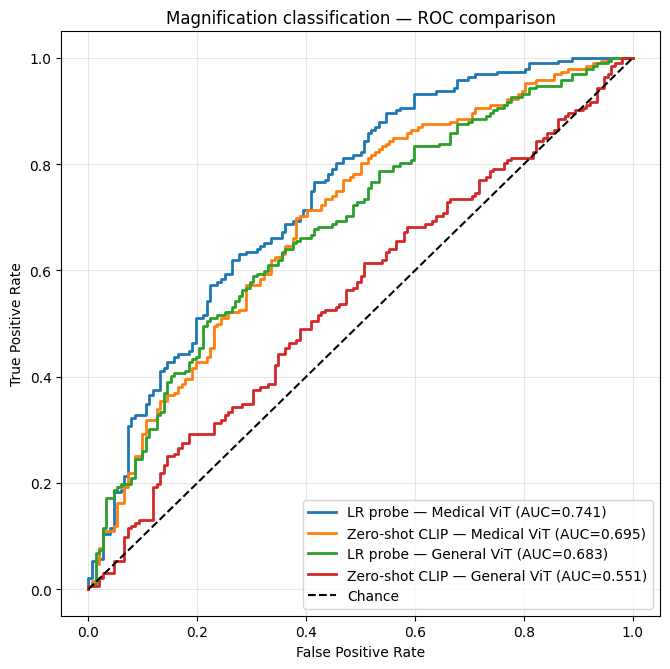

In [29]:
# --- General ViT ---
p_high_gen = zeroshot_clip_scores(
    model_general,
    tokenizer_general,
    img_emb_gen_test,
    PROMPTS,
    device
)

auc_gen = roc_auc_score(y, p_high_gen)
fpr_gen, tpr_gen, _ = roc_curve(y, p_high_gen)

print(f"General ViT zero-shot ROC-AUC: {auc_gen:.3f}")
print(f"General ViT logistic regression ROC-AUC: {lr_gen['auc']:.3f}")

# --- Medical ViT ---
p_high_med = zeroshot_clip_scores(
    model_medical,
    tokenizer_medical,
    img_emb_med_test,
    PROMPTS,
    device
)

auc_med = roc_auc_score(y, p_high_med)
fpr_med, tpr_med, _ = roc_curve(y, p_high_med)


print(f"Medical ViT zero-shot ROC-AUC: {auc_med:.3f}")
print(f"Medical ViT logistic regression ROC-AUC: {lr_med['auc']:.3f}")

plt.figure(figsize=(6.8, 6.8))

# Logistic regression probes
plt.plot(lr_med["fpr"], lr_med["tpr"], lw=2,
         label=f"LR probe — Medical ViT (AUC={lr_med['auc']:.3f})")

# Zero-shot CLIP
plt.plot(fpr_med, tpr_med, lw=2,
         label=f"Zero-shot CLIP — Medical ViT (AUC={auc_med:.3f})")

plt.plot(lr_gen["fpr"], lr_gen["tpr"], lw=2,
         label=f"LR probe — General ViT (AUC={lr_gen['auc']:.3f})")

plt.plot(fpr_gen, tpr_gen, lw=2,
         label=f"Zero-shot CLIP — General ViT (AUC={auc_gen:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Magnification classification — ROC comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


⚠️ *Everything below this line must be submitted as a deliverable for this assignment.*

## Exercises: Practice

#### Exercise 1
Replace the lightweight logistic regression classifier in the linear probing example with custom deep neural network architecture. Justify the model and training hyperparameters and comment on the improvements in the classification performance compared to the linear probing.

#### Exercise 2 

Inspect the content of [Open-MELON](https://huggingface.co/datasets/MartiHan/Open-MELON-VL-2.5K) dataset. Propose 3 possible classification tasks other than predicting the magnification level. Implement the classification using the zero-shot method and report the performance.

#### Exercise 3

One of the most powerful features of CLIP is the ability to search through an image database using free-text queries (semantic retrieval). Define a list of descriptive text queries that might appear in this dataset, for example "dark cells" or "fibrous tissue".

You can perform semantic retrieval in three steps:

1. Encode the text query into an embedding using the Medical model's tokenizer and text encoder.
2. Compute the cosine similarity between the text embedding and the precomputed image embeddings in the dataset.
3. Retrieve and visualize the top 3 matching images (the ones with the highest similarity scores).

Do the retrieved images visually correspond to your text description?

## Flipped Classroom Log

ℹ️ *You have to fill this log for both flipped classroom sessions for this assignment. You only fill the log for your group, not together with the group that you interacted with.*

### Instructions

#### Preparation
* **Clients:** List specific theoretical or implementation (code) questions prepared before class.
* **Consultants:** List papers, videos, or code documentation reviewed to prepare. Note, this is not limited to the material listed above, you can add any new material that you used or found useful. 

#### Peer Interaction
* **Clients:** Summarize the solutions or explanations received.
* **Consultants:** Summarize advice given and specific resources shared.

### Logs
#### First Flipped Classroom


ℹ️ *Write the log for your group in this cell. Should be in a narrative style, aim for a max. of 600 words.*

**Role**: Client/Consultant

**Description** of activities during flipped classroom:

#### Second Flipped Classroom

ℹ️ *Write the log for your group in this cell. Should be in a narrative style, aim for a max. of 600 words.*

**Role**: Client/Consultant

**Description** of activities during flipped classroom: